Paper : [Deep neural networks, gradient-boosted trees,
random forests: Statistical arbitrage on the S&P 500](https://www.econstor.eu/bitstream/10419/130166/1/856307327.pdf)

## Classification framework in Trading

In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr

ticker = 'xom'
start_date = '2000-1-1'
end_date = '2019-1-1'

df = fdr.DataReader(ticker, start_date, end_date)
df.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2000-01-03,39.16,39.75,40.38,38.94,13460000.0,-0.0278
2000-01-04,38.41,38.69,39.09,38.25,14510000.0,-0.0192
2000-01-05,40.50,39.00,40.88,38.91,17490000.0,0.0544
2000-01-06,42.59,40.31,42.91,40.09,19460000.0,0.0516
2000-01-07,42.47,42.97,43.12,42.00,16600000.0,-0.0028


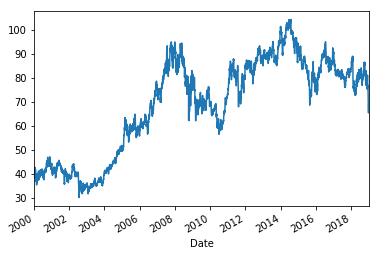

In [3]:
df['Close'].plot()

### Features Contruction

In [4]:
XOM = df
# Features construction 
XOM['Open-Close'] = (XOM.Open - XOM.Close)/XOM.Open
XOM['High-Low'] = (XOM.High - XOM.Low)/XOM.Low
XOM['std_5'] = XOM['Change'].rolling(5).std()
XOM['ret_5'] = XOM['Change'].rolling(5).mean()
XOM.dropna(inplace=True)

# X is the input variable
X = XOM[['Open-Close', 'High-Low', 'std_5', 'ret_5']]

# Y is the target or output variable (target : If tomorrow's price will go up 1, otherwise -1)
y = np.where(XOM['Close'].shift(-1) > XOM['Close'], 1, -1)

### Training ML Model

In [5]:
# Total dataset length
dataset_length = XOM.shape[0]

# Training dataset length
split = int(dataset_length * 0.75)

# Splittiing the X and y into train and test datasets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3581, 4) (1194, 4)
(3581,) (1194,)


In [6]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier


clf1 = GradientBoostingClassifier(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = MLPClassifier(hidden_layer_sizes=(7,3), learning_rate='invscaling' ,random_state=1)
clf = VotingClassifier(estimators=[('gb', clf1), ('rf', clf2), ('nn', clf3)], voting='soft')

# Create the model on train dataset
# clf = tree.DecisionTreeClassifier(random_state=5) # random_state is random seed
model = clf.fit(X_train, y_train)

/Users/cheongyeongja/anaconda3/envs/machine/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [7]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy
print('Correct Prediction: ', accuracy_score(y_test, model.predict(X_test), normalize=False))
print('Total Prediction: ', X_test.shape[0])
print('Accuracy : {} %'.format(accuracy_score(y_test, model.predict(X_test), normalize=True)*100))

Correct Prediction:  591
Total Prediction:  1194
Accuracy : 49.497487437185924 %


### Cross validation for the machine learning model

In [8]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4,shuffle=False)

print("Train: ", "TEST:")
for train_index, test_index in kf.split(X):
     print(train_index, test_index)

Train:  TEST:
[1194 1195 1196 ... 4772 4773 4774] [   0    1    2 ... 1191 1192 1193]
[   0    1    2 ... 4772 4773 4774] [1194 1195 1196 ... 2385 2386 2387]
[   0    1    2 ... 4772 4773 4774] [2388 2389 2390 ... 3579 3580 3581]
[   0    1    2 ... 3579 3580 3581] [3582 3583 3584 ... 4772 4773 4774]


In [9]:
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

/Users/cheongyeongja/anaconda3/envs/machine/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/cheongyeongja/anaconda3/envs/machine/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/cheongyeongja/anaconda3/envs/machine/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/cheongyeongja/anaconda3/envs/machine/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

[49.83249581239531, 49.916247906197654, 50.67001675041875, 50.37720033528919]


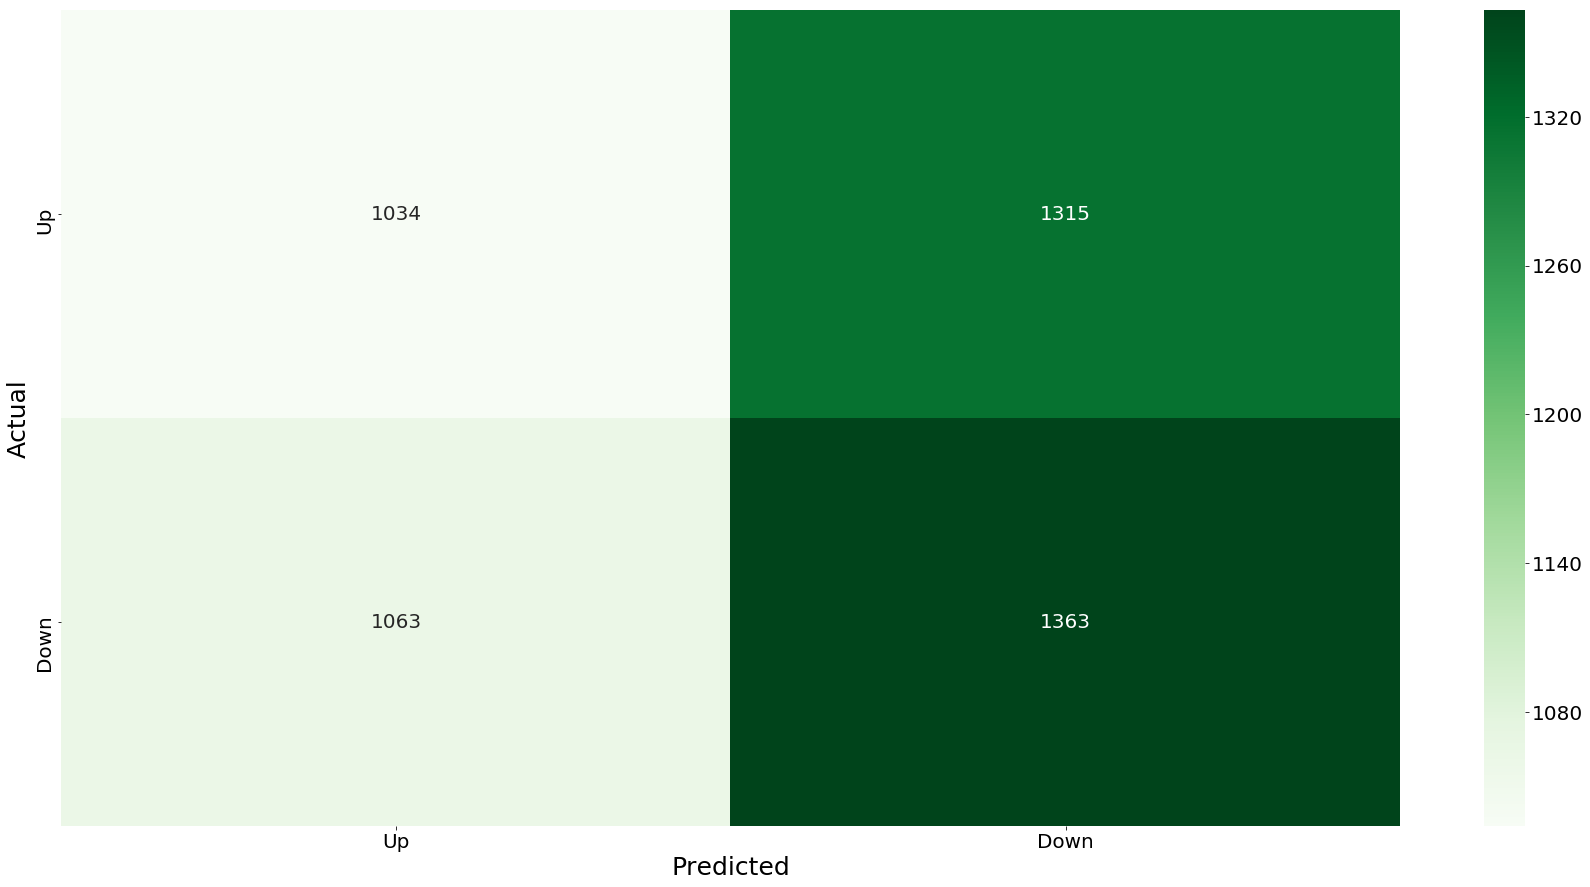

In [10]:
# Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
accuracy_model = []

array = [[0,0],[0,0]]

# Iterate over each train-test split
for train_index, test_index in kf.split(X):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    model = clf.fit(X_train, y_train)
    
    # Append to accuracy_model the accuracy of the model
    accuracy_model.append(accuracy_score(y_test, model.predict(X_test), normalize=True)*100)
    
    c = confusion_matrix(y_test, model.predict(X_test))   
    
    # Add the score to the previous confusion matrix of previous model
    array = array + c

# Print the accuracy    
print(accuracy_model)
   
    
# Create a pandas dataframe that stores the output of confusion matrix        
df = pd.DataFrame(array, index = ['Up', 'Down'], columns = ['Up', 'Down'])

# Plot the heatmap
plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 20})
plt.rc('axes', labelsize = 25)
plt.rc('figure', titlesize = 30)

sn.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Stability of the Model Check

In [11]:
print('Mean :', np.mean(accuracy_model), 'Std :',np.std(accuracy_model))

Mean : 50.198990201075226 Std : 0.3420110394305758
